# Fenomenological Waveform

#### To start we introduce the variables that we are going to use 

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 16 23:12:07 2021

@author: cesartiznado
"""
import numpy as np
import random as rn 
from matplotlib import pyplot as plt
import scipy.signal as sg
import pandas as pd
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
# =============================================================================

# =================== Inicial variables

def cond(Fm,t_ini,t_end,f_0,f_1,t_2,f_driver,Q,seed,OG):
    """
    Fm: Frecuencia de muestreo, 
    t_ini:Tiempo inicial, 
    t_end:Tiempo final,
    f_0: Frecuencia inicial,
    f_1: Frecuencia s=1,
    t_2: Tiempo> Final,
    f_driver: Frecuencia del forzamiento,
    Q: Factor de calidad,
    ran_seed: Semilla aleatoria,
    OG: Número de la WF que utilizamos
    """
    dt = 1/Fm
    N  = np.arange(t_ini,t_end,dt) 
    n  = int(f_driver/(t_end-t_ini))
    t_n1 = np.random.uniform(t_ini,t_end,n) #Set the uniform distribution of t_n
    t_n = np.sort(t_n1)       # t_n in progresive order
    t_s = np.arange(t_ini,t_end,dt) #Time in the inicial interval (simple)
    rn.seed(seed)
    f = np.zeros(len(t_s))    # Set memory to get the frequency
    p_2 = np.zeros(len(t_s))  # Set memory to p_2
    w = np.zeros(len(t_s))    # Set memory to angular frequency
    
    
    for i in range(0,len(t_s)):
        p_1    =  f_1 - f_0 
        p_3    =  t_2 - t_ini
        ab     = (2*t_2-t_ini-1)*(1-t_ini)
        p_2[i] = t_s[i]-t_ini
        f[i] = f_0 + 2*p_1*p_3*(p_2[i])/(ab) - p_1*(p_2[i])**2/(ab)
        w[i] = 2*np.pi*f[i]
    
    return Fm,N,n,t_s,t_n,t_n1,f,w,Q,dt,t_ini,t_end,OG

#### Introduce The Dirac's Delta implementation, who's going to be the forcing in our function.

In [5]:
# =================== Delta implementation

def delta_imp():
    a_n1 = np.random.uniform(-1,1,n) 
    a_n1 =a_n1 *t_n
    a = np.zeros((len(t_s)))
    for i in range(0,len(t_s)):
        for j in range(0,n):
            #s[i,j] =  t_s[i]-t_n[j]
            #a[i] = np.minimum(s[i,:])
            if t_s[i]-t_n[j]<=0 and t_s[i]-t_n[j]>=-15e-6 :     
                #print("-")
                a[i] = a_n1[j]
                i+=1
    return a,a_n1

#### Model implementation

In [6]:
# ============== Model Implementation

def model(): 
    h_t = np.zeros(len(t_s))
    h = np.zeros(len(t_s))
    def F(a,h_t,h,w):
        return a - (w/Q)*h_t - (w**2)*h
    for i in range(0,len(t_s)):
        h_t[i] = h_t[i-1] + F(a[i-1],h_t[i-1],h[i-1],w[i-1])*dt
        h[i] = h[i-1] + h_t[i-1]*dt
    hrms = 1e13
    h = h/hrms
    h = h/2
    #h = h/max(abs(h))
    return h

#### Resample of the data 

In [7]:

# ========================== Resample to 16386

sample = 16386
def sn_resample_wave(t,h,fs):
    """
    Interpolate array h to the fs sampling frequency.
   
    Input:
        t  - time array, in seconds
        h  - strain array to be interpolated
        fs - thi is the new sampling frequency
    Output:
        t1 - time array, after resampling
        h1 - new strain array
    """
   
    # Quick check
    if len(t)!=len(h):
        print("Error: t and h need to have equal sizes")
        return 0
   
    # Define new time with fs
    t1 = np.arange(t[0],t[-1],1.0/fs)
   
    # Interpolation
    tck = interpolate.splrep(t,h,s=0)
    h1  = interpolate.splev(t1,tck,der=0)
   
    return t1, h1

#### Padding zeros to the signal

In [8]:
# ================ Add zeros to the angular frequeny,frequency, the signal and time
def pad_zeros():
    tright = np.arange(t_end,1.0,dt)
    tz = np.append(t_s,tright)
        
    hsr = np.zeros(len(tright))
    hz  = np.append(h,hsr)
    
    wr = np.zeros(len(tright))
    wz = np.append(w,wr)
    
    fr = np.zeros(len(tright))
    fz = np.append(f,fr)
    return tz,wz,fz,hz

#### Save the data in a .csv file . 

In [9]:
def save(datog):
    datog = pd.DataFrame()
    datog["Time"] = tz
    datog["Frequency"] = fz
    datog["Signal"] = hz
    # datog["SG_Time"] = t
    # datog["SG_Strain"] = hx_SG
    return datog.to_csv("Datog"+str(OG)+".csv",header=True,index = False)

#### Set the initial conditions of the template

In [10]:
# =============================================================================
# Inicial Conditions of our Perturbartion
# =============================================================================
# =============== WF_1
#Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,1100,.6,600,10,8,1)

# =============== WF_2
#Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.2,100,400,.4,100,1,8,2)

# =============== WF_3
Fm,N,n,t_s,t_n,t_n1,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,1.25,200,10,8,3)

# =============== WF_4

#Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.2,0.9,300,1400,1.2,400,10,8,4)

# =============== WF_5
#Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.1,0.6,150,800,.8,250,1,8,5)

#### Execute All the functions to a determinate values.

In [11]:
# =============================================================================
# Call de functions to execute the instructions
# =============================================================================

a,a_n1  = delta_imp()                  #Dirac Delta
h = model()                            #Strain
tz,wz,fz,hz = pad_zeros()              #Paddig zeros to the signal 
t1res,h1res = sn_resample_wave(tz,hz,sample) #Resample to LIGO frequency
#hp = wfSG(sample)                      #hp polarization in Sine Gaussian waveforms

#### We would determinate the Hrss, that obeys $h_{rss} \equiv \sqrt{\int{h(t)^{2} dt}}$ 


In [12]:
def Calc_hrss(h,t):
    hrss = (h[-1]**2 * t[-1]) - (h[0]**2 * t[0])
    hrss = np.sqrt(hrss)
    print("The real valor of $h_{rss}$ : ", hrss)
    return hrss 
hrss = Calc_hrss(h,t_s)



The real valor of $h_{rss}$ :  7.615063812570063e-25


#### Plot the Spectrogram of the Waveform.

In [13]:
# ===================== Spectrogram

wnd="hamming"
nfft=4*4096
nperseg=4096
noverlap=4096-512

def spectrogram(h,Fm):
    """ Función para la creación del espectrograma
    h: Señal
    Fm: Frecuencia de Muestreo
    """
    f,t,Sxx = sg.spectrogram(h, Fm, window=wnd, nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')
    return f,t,Sxx    


fxz, txz, Sxz = sg.spectrogram(hz, Fm, window=wnd, nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')
txz = txz + tz[0] # Recorrer el espectrograma

#### Create a directory to the images and plot all of them

C:\Users\PC\Desktop\Tesis\Fen_tiz
C:\Users\PC\Desktop\Tesis\Fen_tiz\Images\
The directory: {0} C:\Users\PC\Desktop\Tesis\Fen_tiz\Images\ Already exist


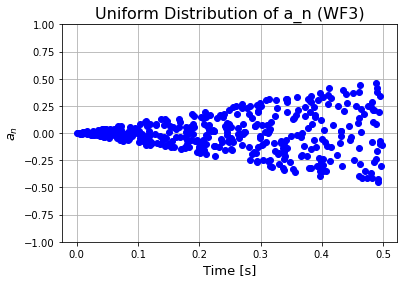

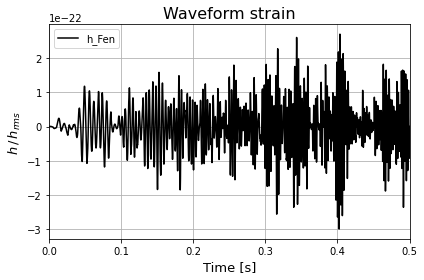

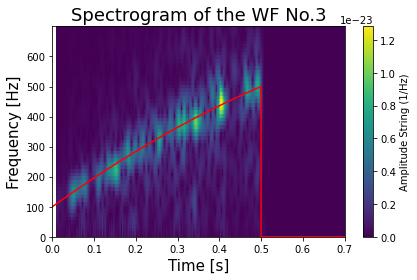

In [14]:
import os

# Create a folder to save all the plots
print(os.getcwd())
print(os.getcwd() + "\\Images\\")


path = os.getcwd() + "\\Images\\"  #"C:\\Users\\PC\\Desktop\\Tesis\\Fen_tiz\\Images\\"

try:
    os.mkdir(path)
    print("The directory: {0}",path,"Created")
except FileExistsError:
    print("The directory: {0}",path,"Already exist")

# ===============PLot a(t) implementation

plt.plot(t_n,a_n1,"ob")
plt.title("Uniform Distribution of a_n (WF" + str(OG) + ")", fontsize=16)
plt.ylabel("$a_{n}$", fontsize=13)
plt.xlabel("Time [s]", fontsize=13)
#plt.xlim(-.5,1.5)
plt.ylim(-1,1)
plt.grid()
plt.savefig(path +"a_n("+ str(OG)+").png",dpi=400)
plt.show()

# ======================== Plot the waveforms
plt.figure()
#plt.plot(to,hpo,label='hplus')
plt.plot(t1res,h1res,"black",label="h_Fen")
#plt.plot(to,hco,label='hcross')
#plt.plot(t,hx_SG,label="hcrossSG")
plt.title("Waveform strain", fontsize=16)
plt.xlabel('Time [s]', fontsize=13)
plt.ylabel('$h \,/ \, h_{rms}$', fontsize=13)
plt.xlim(0,.5)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(path + "WF.png",dpi=400)
plt.show()

# =============================================================================
#  Plot Spectrogram
# =============================================================================
plt.figure()
plt.pcolormesh(txz, fxz, Sxz,shading="auto")
plt.plot(tz,fz,"r")
plt.title("Spectrogram of the WF No." + str(OG),fontsize=18)
cbar = plt.colorbar()
cbar.set_label('Amplitude String (1/Hz)')
plt.ylim([0,max(fz) +200])
plt.ylabel('Frequency [Hz]',fontsize=15)
plt.xlabel('Time [s]',fontsize=15)
plt.xlim(0,0.7)
plt.tight_layout()
plt.savefig(path + "Spec_WF_No"+ str(OG) + ".png",dpi=400)
plt.show()

### The evolution of the frequency in t_2 and why must be grather than the t_end 

In [15]:
# def plot_spectrogram(f,t,Sxx,t2,ax=None,**Kwargs):    
#     """ Función para plotear el espectrograma
#     """
#     plt.figure()
#     plt.pcolormesh(t, f, Sxx,shading="auto")
#     #plt.plot(t_s,f,"r")
#     plt.title("Spectrogram of the signal OG" + str(OG)+ str(t2),fontsize=18)
#     cbar = plt.colorbar()
#     cbar.set_label('Amplitude String (1/Hz)')
#     plt.ylim([-50,max(f) +100])
#     plt.ylabel('Frequency [Hz]',fontsize=15)
#     plt.xlabel('Time [s]',fontsize=15)
#     #plt.xlim(0,0.7)
#     plt.tight_layout()

#     #plt.savefig(path + "Spec_OG_"+ str(OG) + str(t2) +".png",dpi=400)
#     plt.show()


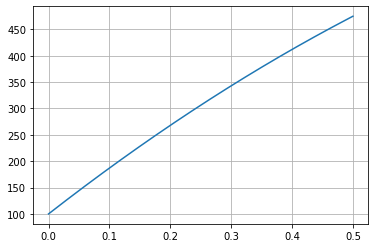

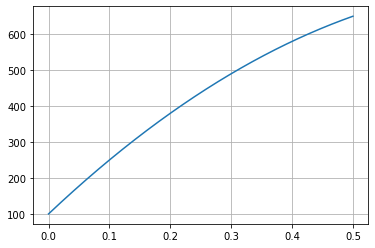

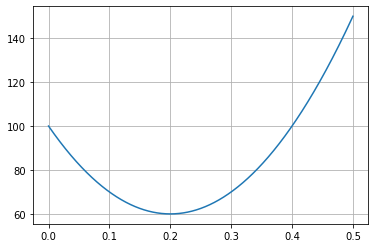

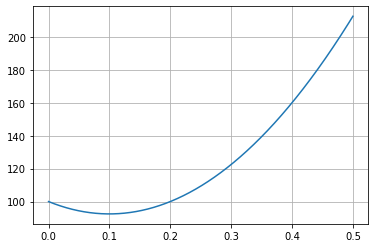

<Figure size 432x288 with 0 Axes>

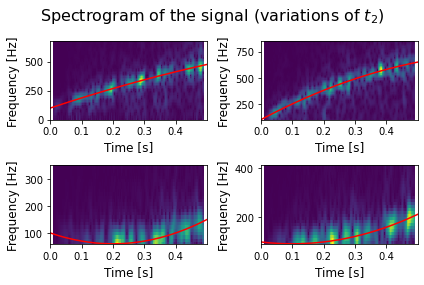

In [16]:
# Check the frequency

# As we see in the paper, t_2 should be great than t_{end} 

# Fm,N,n,t_s,t_n,t_n1,f1,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,1.25,200,10,8,3)
t2_1=1.5
t2_2=0.8
t2_3 = 0.2
t2_4 = 0.1


Fm,N,n,t_s,t_n,t_n1,f1,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,t2_1,200,10,8,3)
plt.plot(t_s,f1)
plt.grid()
plt.show()

a,a_n1  = delta_imp()                  #Dirac Delta
h1 = model() 
fs1,ts1,Sxx1 = spectrogram(h1,Fm)

Fm,N,n,t_s,t_n,t_n1,f2,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,t2_2,200,10,8,3)
plt.plot(t_s,f2)
plt.grid()
plt.show()

a,a_n1  = delta_imp()                  #Dirac Delta
h2 = model() 
fs2,ts2,Sxx2 = spectrogram(h2,Fm)

Fm,N,n,t_s,t_n,t_n1,f3,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,t2_3,200,10,8,3)
plt.plot(t_s,f3)
plt.grid()
plt.show()

a,a_n1  = delta_imp()                  #Dirac Delta
h3 = model() 
fs3,ts3,Sxx3 = spectrogram(h3,Fm)

Fm,N,n,t_s,t_n,t_n1,f4,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,t2_4,200,10,8,3)
plt.plot(t_s,f4)
plt.grid()
plt.show()

a,a_n1  = delta_imp()                  #Dirac Delta
h4 = model() 
fs4,ts4,Sxx4 = spectrogram(h4,Fm)



<Figure size 432x288 with 0 Axes>

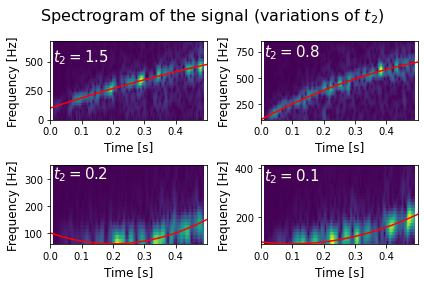

In [70]:
plt.figure()
fig,axs = plt.subplots(2,2,tight_layout = True)
plt.suptitle("Spectrogram of the signal (variations of $t_{2}$)",fontsize=16)
axs[0,0].pcolormesh(ts1, fs1, Sxx1,shading="auto")
axs[0,0].plot(t_s,f1,"r")
axs[0,0].set_ylim([0,max(f1) +200])
axs[0,0].set_ylabel('Frequency [Hz]',fontsize=12)
axs[0,0].set_xlabel('Time [s]',fontsize=12)
axs[0,0].set_xlim([0,max(t_s)])
axs[0,0].text(0.01,500,"$t_{2} = $" + str(t2_1),{'color': 'ivory', 'fontsize': 15})

axs[0,1].pcolormesh(ts2, fs2, Sxx2,shading="auto")
axs[0,1].plot(t_s,f2,"r")
axs[0,1].set_ylim([min(f2),max(f2) +200])
axs[0,1].set_ylabel('Frequency [Hz]',fontsize=12)
axs[0,1].set_xlabel('Time [s]',fontsize=12)
axs[0,1].set_xlim([0,max(t_s)])
axs[0,1].text(0.01,700,"$t_{2} = $" + str(t2_2),{'color': 'ivory', 'fontsize': 15})

axs[1,0].pcolormesh(ts3, fs3, Sxx3,shading="auto")
axs[1,0].plot(t_s,f3,"r")
axs[1,0].set_ylim([min(f3),max(f3) +200])
axs[1,0].set_ylabel('Frequency [Hz]',fontsize=12)
axs[1,0].set_xlabel('Time [s]',fontsize=12)
axs[1,0].set_xlim([0,max(t_s) ])
axs[1,0].text(0.01,300,"$t_{2} = $" + str(t2_3),{'color': 'ivory', 'fontsize': 15})

axs[1,1].pcolormesh(ts4, fs4, Sxx4, shading="auto")
axs[1,1].plot(t_s,f4,"r")
axs[1,1].set_ylim([min(f4),max(f4) +200])
axs[1,1].set_ylabel('Frequency [Hz]',fontsize=12)
axs[1,1].set_xlabel('Time [s]',fontsize=12)
axs[1,1].set_xlim([0,max(t_s) ])
axs[1,1].text(0.01,350,"$t_{2} = $" + str(t2_4),{'color': 'ivory', 'fontsize': 15})

plt.tight_layout()
plt.savefig(path + "Spec_WF_"+ str(OG)+ "changet2_" + str(t2_1) +".png",dpi=400)
plt.show()



In [17]:
# Read Ligo data and convert in a Df
# =====================================


data = pd.read_csv(r"C:\Users\PC\Desktop\Tesis\Fen_tiz\LIGO_sensdata\L1_02.txt",header = None,delim_whitespace=True)
data1 = pd.read_csv(r"C:\Users\PC\Desktop\Tesis\Fen_tiz\LIGO_sensdata\H1_02.txt",header = None,delim_whitespace=True)
# #data2 = pd.read_csv("L1_03.txt",header = None,delim_whitespace=True)

L1_02t = data[0]
H1_02t = data1[0]
# #L1_03t = data2[0]

L1_02f = data[1]
H1_02f = data1[1]
# #L1_03f = data2[1]

In [18]:
def Fourier_transform(t1,h1):
    from scipy import fftpack
    """
    t1: The time of the original signal
    h1: The original signal h(t)
    # => Return
    H: h(f)
    fr: The frecuency get of h
    """
    dt = t1[1] - t1[0]

    #Fourier Transform
    H = dt*fftpack.fft(h1)
    fr = fftpack.fftfreq(len(t1),dt)

    #Shift Data in normal order
    fr = fftpack.fftshift(fr)
    H = dt*fftpack.fftshift(H)

    # use only real data from m/2+1 (freq>0) to m-1
    # double- to one-sided
    m = len(fr)
    fr = fr[int(m/2)+1:m-1]
    H = 2*H[int(m/2)+1:m-1] 
    return fr,H

def hchar(fr,H):
    """ Characteristic Strain of the Waveform
    fr:Frecuency of h
    H: h(f)
    # => Return
    hchar: Characteristic Strain h
    fchar: Characteristic Frequency
    """
    #Strain característico
    hchar = fr * H
    hchar = abs(hchar)
    print(hchar)
    fchar = fr
    return hchar,fchar
    
def medfilt(hchar,n):    
    """ Median filter to a output array
    hchar: Characteristic Strain
    n: The size of the median filter window
    """
    #Smooth
    hchar = sg.medfilt(abs(hchar),n)
    print(hchar)
    return hchar
    
def root_psd(hchar,fchar):
    """sd
    """    
    #SROOT PSD SIGNAL
    Root_psd_wave =  hchar * fchar**(-0.5)
    return Root_psd_wave

def peak(fchar,Spect_wave):
    lem = np.argmax(Spect_wave)
    fchar_peak = fchar[lem]
    root_peak = Spect_wave[lem]

    return fchar_peak,root_peak
# =============== Root_PSD    
fr,H = Fourier_transform(t1res,h1res)
hchar,fchar = hchar(fr,H)
hchar = medfilt(hchar,5)
Spect_wave = root_psd(hchar,fchar)
fpeak,root_peak = peak(fchar,Spect_wave)


# Escalable
Spect_waveh1 = Spect_wave/(12e-5/6)
fpeak1,root_peak1 = peak(fchar,Spect_waveh1)

Spect_waveh2 = Spect_wave/(12e-4/6)
fpeak2,root_peak2 = peak(fchar,Spect_waveh2)

Spect_waveh3 = Spect_wave/(12e-3/6)
fpeak3,root_peak3 = peak(fchar,Spect_waveh3)





[3.66690936e-29 6.22910445e-29 1.05061080e-28 ... 1.50056214e-27
 1.67805645e-27 9.90717919e-28]
[3.66690936e-29 6.22910445e-29 1.05061080e-28 ... 1.36577212e-27
 9.90717919e-28 9.90717919e-28]


In [28]:
h1 = (h * 12e-5)/6  
h2 = (h * 12e-4)/6
h3 = (h * 12e-3)/6

hrss1 = Calc_hrss(h1,t_s)
hrss2 = Calc_hrss(h2,t_s)
hrss3 = Calc_hrss(h3,t_s)

hrss1 = Calc_hrss(h1,t_s)
hrss2 = Calc_hrss(h2,t_s)
hrss3 = Calc_hrss(h3,t_s)

print(format(hrss1,".2e"))


The real valor of $h_{rss}$ :  1.5230127625140128e-29
The real valor of $h_{rss}$ :  1.5230127625140125e-28
The real valor of $h_{rss}$ :  1.5230127625140128e-27
1.52e-29


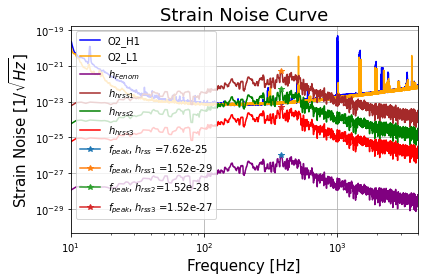

In [40]:
plt.title("Strain Noise Curve", fontsize=18)
plt.loglog(H1_02t,H1_02f,color="blue",label="O2_H1")
plt.loglog(L1_02t,L1_02f,color="Orange",label="O2_L1")
#plt.loglog(L1_03t,L1_03f,color="green",label="O3_L1")
#plt.plot(fchar, spect_wave_hc,label='hcross SineGaussian',color="red")
#plt.plot(fenchar, spect_wave_hf,label='h Fenom',color="purple")
plt.plot(fchar,Spect_wave, label='$h_{Fenom}$',color="purple")
plt.plot(fchar,Spect_waveh1, label='$h_{hrss1}$',color="brown")
plt.plot(fchar,Spect_waveh2, label='$h_{hrss2}$',color="green")
plt.plot(fchar,Spect_waveh3, label='$h_{hrss3}$',color="red")
plt.plot(fpeak,root_peak, marker="*",label="$f_{peak},h_{rss}$ =" + str(format(hrss,".2e")))
plt.plot(fpeak,root_peak1, marker="*",label="$f_{peak}, h_{rss1}$ =" + str(format(hrss1,".2e")))
plt.plot(fpeak,root_peak2, marker="*",label="$f_{peak}, h_{rss2}$=" + str(format(hrss2,".2e")))
plt.plot(fpeak,root_peak3, marker="*",label="$f_{peak}, h_{rss3}$ =" + str(format(hrss3,".2e")))
plt.xlabel("Frequency [Hz]",fontsize=15)
plt.ylabel("Strain Noise [$1/\sqrt{Hz}$]",fontsize=15)
plt.xlim(10,4.0e3)
#plt.ylim([1.0e-28,7.0e-21])
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig(path + "WF"+str(OG)+"Noise.png",dpi=200)